<a href="https://colab.research.google.com/github/vazraul/VEnergy/blob/main/Case_VEnergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução
A necessidade de inovação no setor de energia é constante, dados os desafios
econômicos e ambientais envolvidos. Dentre os principais interessados destacam-se
os grandes consumidores de energia (indústrias pesadas) que buscam aumentar sua
eficiência operacional e reduzir seu impacto ambiental.
Nesse nicho posiciona-se a VEnergy, uma empresa de soluções de gestão
energética para indústrias com forte atuação na América Latina. Ela tem uma linha
completa de soluções que permitem aos grandes consumidores gerirem com mais
inteligência seu consumo energético.

# Soluções de gerenciamento de energia e peak shaving:
Em linhas gerais, a tarifa elétrica pode ser cobrada por demanda de potência e/ou
consumo de energia elétrica a depender do tipo de consumidor. No caso de
consumidores de alta tensão, como os clientes da VEnergy, a cobrança é feita
majoritariamente por demanda. Nesse sentido, os consumidores possuem contratos
firmados com empresas distribuidoras e comercializadoras para garantir uma
demanda contratada compatível com suas necessidades.
As agências reguladoras, por sua vez, geralmente adotam políticas que desincentivam
o consumo em horas de alta demanda da rede, as chamadas horas ponta, cobrando
tarifas mais elevadas. Por esse motivo, é importante que os grandes consumidores
1
tenham uma boa estratégia de gestão energética, a qual seja capaz de gerenciar a
demanda de energia tendo em vista essa variabilidade do custo.
Uma técnica cada vez mais empregada é o peak shaving, um processo de redução da
quantidade de energia comprada - ou perfil de corte - das concessionárias durante
os horários de pico de demanda de energia para reduzir as cobranças de demanda
de pico. Em outras palavras, consiste em ‘aplainar’ o perfil de carga.

De forma simplificada, isso é realizado por meio de um sistema inteligente que possui:
1. Um sistema de armazenamento de energia (SAE), geralmente composto de um
banco de baterias, o qual armazena energia durante os horários fora de ponta e é
utilizado para alimentar a operação durante os períodos de hora ponta;
2. Um sistema de detecção/predição de pico de demanda de potência intra
diário na rede que sinaliza o momento correto de chaveamento da operação
para o sistema de armazenamento de energia (SAE);

#Desafio


O objetivo deste projeto é desenvolver um modelo preditivo capaz de prever com precisão os picos de consumo de energia com base em dados históricos. A ideia é utilizar essas previsões para otimizar o uso da energia elétrica, permitindo o corte do consumo direto da rede de alimentação elétrica durante os períodos de pico.

A solução proposta envolve o uso de técnicas avançadas de análise de dados e aprendizado de máquina para extrair padrões e tendências dos dados históricos de consumo de energia. Com base nesses insights, o modelo poderá fazer previsões confiáveis sobre os momentos de maior demanda de energia.


Para atingir esse objetivo, será importante realizar uma análise detalhada dos dados disponíveis, identificar possíveis variáveis relevantes para a previsão de picos de energia e selecionar os algoritmos de aprendizado de máquina mais adequados para o problema.

Ao final do projeto, esperamos ter um modelo robusto e preciso, capaz de auxiliar empresas e organizações a otimizarem seu consumo de energia, reduzindo custos e tornando suas operações mais sustentáveis e eficientes."

#Imports

In [10]:
#Import das libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import datetime as dt
from datetime import timedelta
import itertools
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score,
                             mean_absolute_error,
                             mean_squared_error,
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
plt.style.use("ggplot")

pd.set_option('display.max_rows', 200)

In [11]:
!pip install --upgrade xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [12]:
# Configurando a exibição dos gráficos
import matplotlib.font_manager
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "Calibri"
plt.style.use("ggplot")
teal = "#00C0D2"
light_blue = "#4251BC"
blue = "#262E6C"
dark_blue = "#111530"
black = "#000000"
cian = "#4AA6EE"

In [13]:


df_demanda = pd.read_csv('/content/Histórico Demanda Elétrica Peru 2006 - 2021-09.csv' ,sep=',', header=0)
df_temp = pd.read_csv('/content/Tempo Lima 2006 - 2021-10.csv',
                      sep=',',
                      header=0,
                      na_values=['S-D'])



In [14]:
df_demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552192 entries, 0 to 552191
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       552192 non-null  object 
 1   executado  552192 non-null  float64
dtypes: float64(1), object(1)
memory usage: 8.4+ MB


In [15]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119824 entries, 0 to 119823
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DATE    119824 non-null  object 
 1   HOUR    119001 non-null  object 
 2   TEMP    101913 non-null  float64
 3   PREC_H  75586 non-null   float64
 4   HUM     101942 non-null  float64
 5   W_DIR   101927 non-null  float64
 6   W_VEL   101929 non-null  float64
dtypes: float64(5), object(2)
memory usage: 6.4+ MB


#1 - Data Prep

###Preparação dos dados de temperatura

In [16]:
#Temperatura
df_tempo = df_temp.copy()
df_tempo["DATETIME"] = df_tempo["DATE"] + " " + df_tempo["HOUR"]
df_tempo["DATETIME"] = pd.to_datetime(df_tempo["DATETIME"])
df_tempo = df_tempo.drop(columns=['DATE','HOUR'])

# Tratando dados nulos
df_tempo = df_tempo.dropna()
#df_tempo.drop_duplicates(subset=['DATETIME'])

#Upsample e interpolação
df_tempo.set_index("DATETIME", inplace=True)
df_tempo = df_tempo.resample('15min').interpolate(method='linear')

###Preparação dos dados de potência

In [17]:
#Demanda Potencia
df_demanda_potencia = df_demanda.copy()
df_demanda_potencia["Date"] = pd.to_datetime(df_demanda_potencia["date"])
df_demanda_potencia = df_demanda_potencia.drop(columns=["date"])
df_demanda_potencia["dataref"] = df_demanda_potencia["Date"].dt.strftime("%Y%m%d")
df_demanda_potencia["ano"] = df_demanda_potencia["Date"].dt.year
df_demanda_potencia["mes"] = df_demanda_potencia["Date"].dt.month
df_demanda_potencia["semana"] = (df_demanda_potencia["Date"].dt.isocalendar().week).astype(int)
df_demanda_potencia["dia"] = df_demanda_potencia["Date"].dt.day
df_demanda_potencia["dia_semana"] = df_demanda_potencia["Date"].dt.dayofweek
df_demanda_potencia["hora"] = df_demanda_potencia["Date"].dt.hour
df_demanda_potencia["minuto"] = df_demanda_potencia["Date"].dt.minute
df_demanda_potencia["hora-minuto"] = df_demanda_potencia["Date"].dt.strftime('%H:%M')

In [18]:
#Marcando o horário de pico do dia
df_demanda_potencia2 = df_demanda_potencia.loc[(17 <= df_demanda_potencia["hora"]) & (df_demanda_potencia["hora"] <= 23)]
idx_picos = df_demanda_potencia2.groupby("dataref")["executado"].idxmax()

df_demanda_potencia["pico"] = 0
df_demanda_potencia.loc[idx_picos, "pico"] = 1

df_demanda_potencia.set_index("Date", inplace=True)


#2 - Análise Exploratória


###Como se comporta a demanda elétrica ao longo dos anos, meses, semanas, dias?

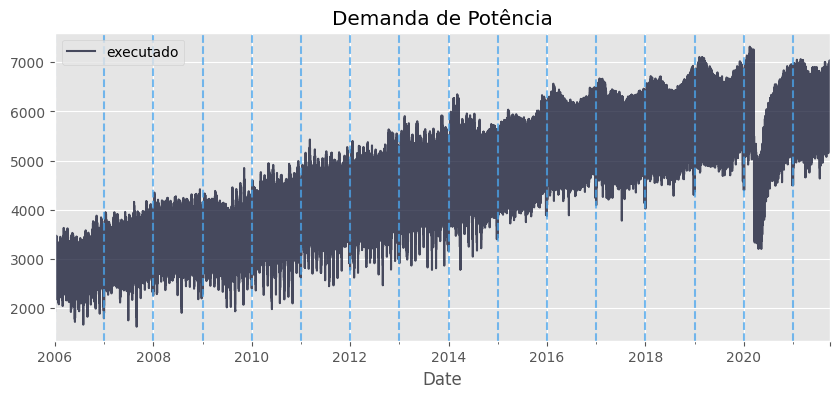

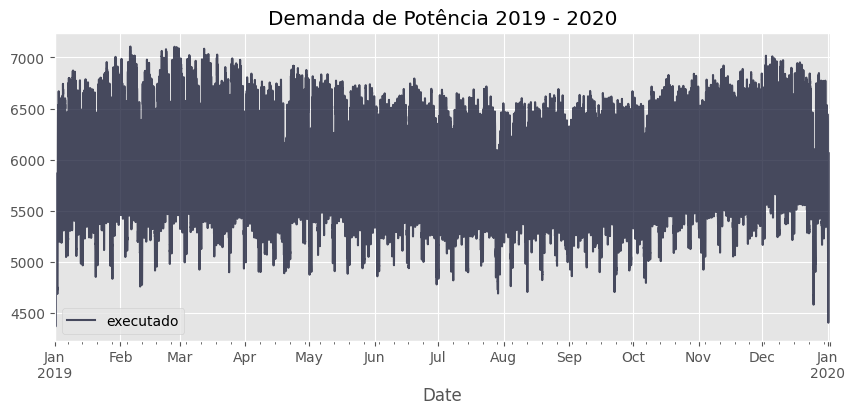

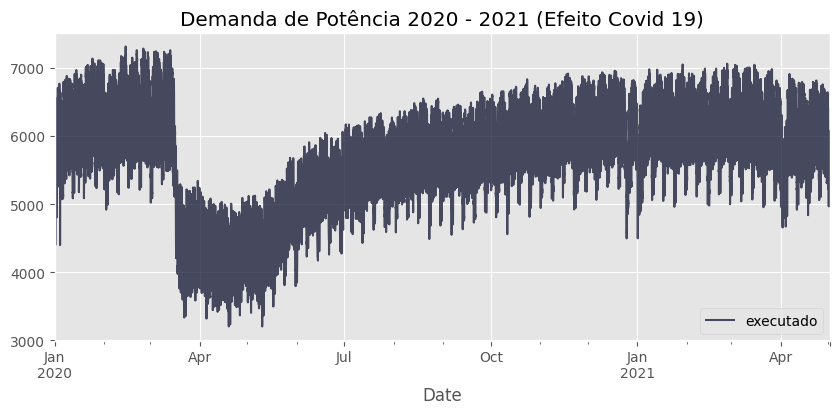

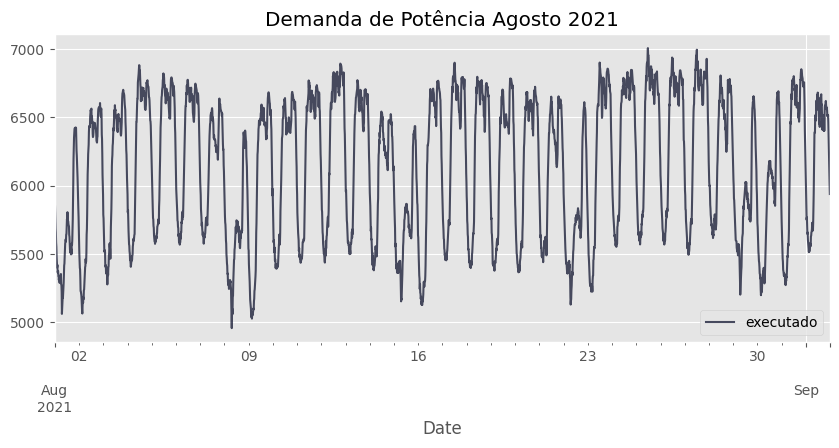

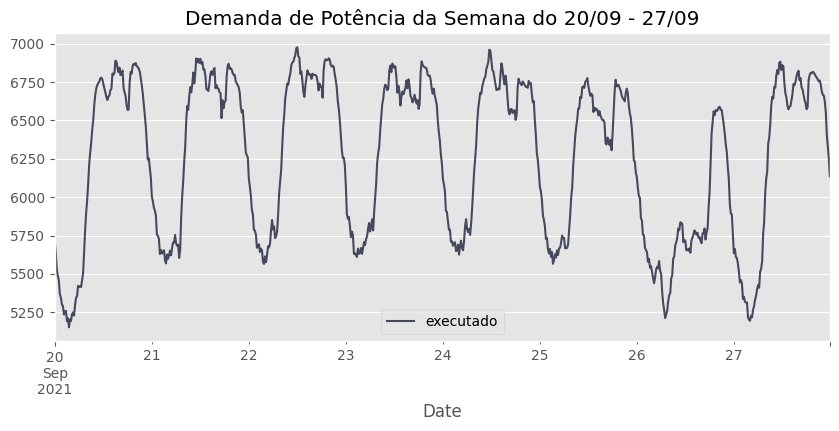

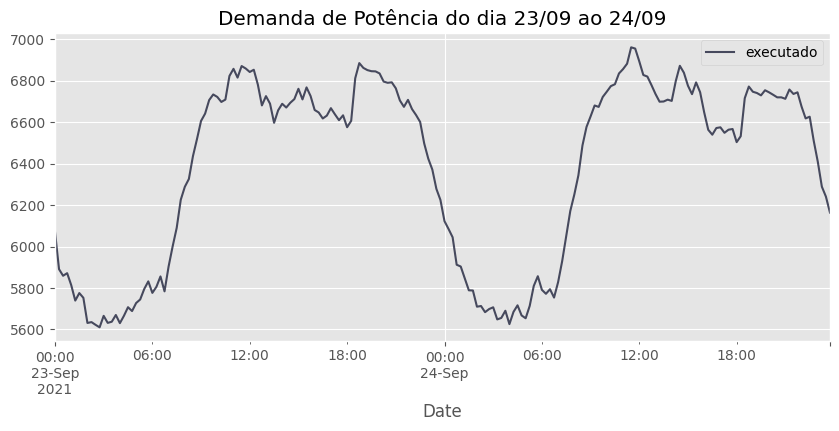

In [19]:
#Plots
ax = df_demanda_potencia.plot(
    y="executado", figsize=(10, 4), title="Demanda de Potência", c=dark_blue, alpha=0.75,
)

for y in np.arange(2000, 2022):
    ax.axvline(dt.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_demanda_potencia.loc["2019-01-01":"2020-01-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência 2019 - 2020",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

df_demanda_potencia.loc["2020-01-01":"2021-05-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência 2020 - 2021 (Efeito Covid 19)",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

start_month = "2021-08-01"
end_month = "2021-09-01"

df_demanda_potencia.loc[start_month:end_month].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência Agosto 2021",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

start_week = "2021-09-20"
end_week = "2021-09-27"

df_demanda_potencia.loc[start_week:end_week].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência da Semana do 20/09 - 27/09",
    c=dark_blue,
    alpha=0.75,
)
plt.show()


start_week = "2021-09-23"
end_week = "2021-09-24"

df_demanda_potencia.loc[start_week:end_week].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência do dia 23/09 ao 24/09",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

In [20]:
#Podemos modelar o crescimento esperado da demanda?
df_demanda_potencia["DATE"] = pd.to_datetime(df_demanda_potencia.index)
df_demanda_potencia["ORDINAL_DATE"] = df_demanda_potencia["DATE"].apply(
    lambda x: time.mktime(x.timetuple())
)


lin_regr = LinearRegression(fit_intercept=True)
x = df_demanda_potencia.dropna(subset=["executado", "ORDINAL_DATE"])[
    "ORDINAL_DATE"
].values.reshape(-1, 1)
y = df_demanda_potencia.dropna(subset=["executado", "ORDINAL_DATE"])["executado"].values.reshape(
    -1, 1
)

lin_regr.fit(x, y)
print("LinReg Slope (per timestep):", lin_regr.coef_[0])
print("LinReg Intercept:", lin_regr.intercept_)
print("LinReg Slope (per month):", lin_regr.coef_[0] * 48 * 30)
print("LinReg Slope (per year):", lin_regr.coef_[0] * 48 * 365)

LinReg Slope (per timestep): [7.32692735e-06]
LinReg Intercept: [-5561.51890947]
LinReg Slope (per month): [0.01055078]
LinReg Slope (per year): [0.12836777]


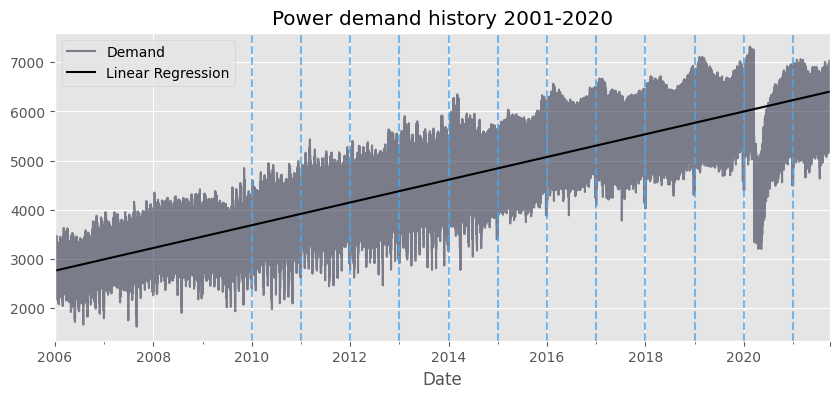

In [21]:
df_demanda_potencia["LINREG"] = lin_regr.predict(
    df_demanda_potencia["ORDINAL_DATE"].values.reshape(-1, 1)
)
ax = df_demanda_potencia.plot(
    y="executado",
    figsize=(10, 4),
    title="Power demand history 2001-2020",
    c=dark_blue,
    alpha=0.5,
    label="Demand",
)
for y in np.arange(2010, 2022):
    ax.axvline(dt.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
df_demanda_potencia.plot(y="LINREG", figsize=(10, 4), c="k", ax=ax, label="Linear Regression")
plt.show()

###Distribuição da Demanda

Text(0.5, 1.0, 'Distribuição de Probabilidade da Demanda 2018-2021')

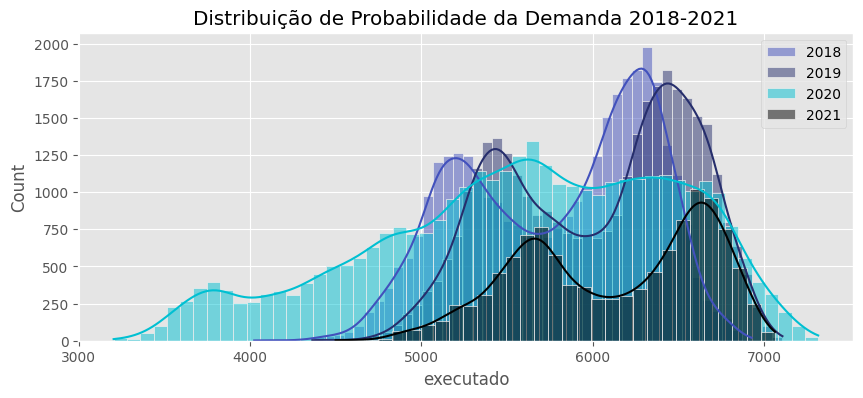

In [22]:
ax = sns.histplot(
    df_demanda_potencia.loc["2018-01-01":"2019-01-01"]["executado"], kde=True, label="2018", color=light_blue
)

sns.histplot(
    df_demanda_potencia.loc["2019-01-01":"2020-01-01"]["executado"], kde=True,
    label="2019",
    color=blue,
    ax=ax,
)
sns.histplot(
    df_demanda_potencia.loc["2020-01-01":"2021-01-01"]["executado"], kde=True,
    label="2020",
    color=teal,
    ax=ax,
)
sns.histplot(
    df_demanda_potencia.loc["2021-01-01":"2021-05-01"]["executado"], kde=True,
    label="2021",
    color=black,
    ax=ax,
)
ax.legend()
ax.set_title("Distribuição de Probabilidade da Demanda 2018-2021")

*Insight 1: A demanda segue uma distribuição de probabilidade bimodal com deslocamento ano após ano.
As modas são gerados pela sasonalidade diária de picos (diurno) e vales (noturno).*

*Insight 2: 2020 ocorre uma mudança do padrão, marcado por um espessamento da cauda à esquerda*

###Estudo dos Picos

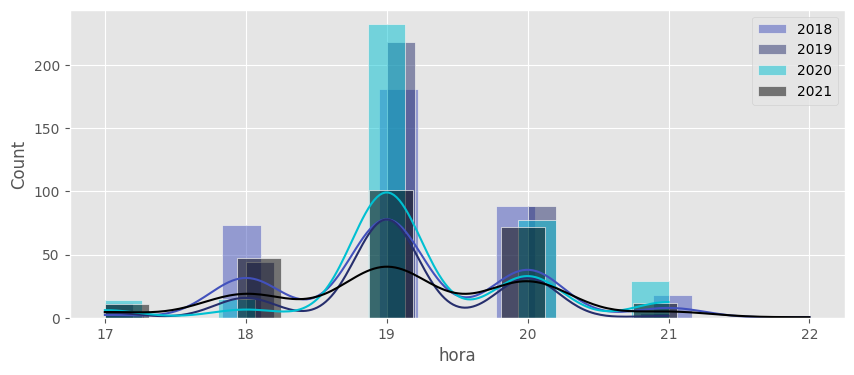

In [23]:
#Como se dá a ocorrência dos picos ao longo dos anos?
df_demanda_pico = df_demanda_potencia[df_demanda_potencia["pico"] == 1].copy()


ax = sns.histplot(
    df_demanda_pico.loc["2018-01-01":"2019-01-01"]["hora"], label="2018", color=light_blue, kde=True
)
sns.histplot(
    df_demanda_pico.loc["2019-01-01":"2020-01-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2020-01-01":"2021-01-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2021-01-01":"2021-09-01"]["hora"], label="2021", color=black, ax=ax,kde=True
)

ax.legend()

*Insight: Há uma clara mudança do padrão de ocorrência do pico intra diário a partir de 2021, onde a densidade em torno das 20h passa a ser tão significante quanto em torno das 19h*

### Estudo dos efeitos de "lag" da demanda

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


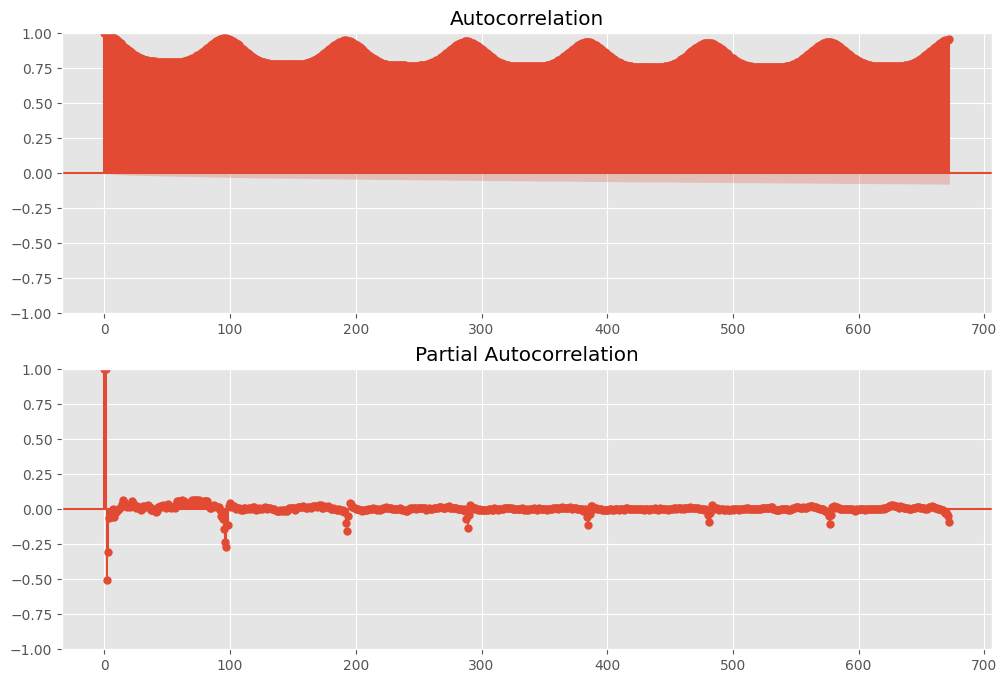

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_demanda_potencia['executado'], lags=7*24*60//15, ax=ax1) #
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_demanda_potencia['executado'], lags=7*24*60//15, ax=ax2)# , lags=40

*Insight:* existe uma sazonalidade predominantemente diária (múltiplos de 96, pois $24h/dia \times 60min/h / 15min$) nos dados de consumo de energia.

###Temperatura

In [25]:
df_tempo.head()

,TEMP,PREC_H,HUM,W_DIR,W_VEL
DATETIME,,,,,
2006-11-02 15:00:00,19.100000,0.0,86.000000,241.000000,1.200000
2006-11-02 15:15:00,19.099853,0.0,86.000733,240.998167,1.199927
2006-11-02 15:30:00,19.099707,0.0,86.001466,240.996334,1.199853
2006-11-02 15:45:00,19.099560,0.0,86.002199,240.994501,1.199780
2006-11-02 16:00:00,19.099413,0.0,86.002933,240.992669,1.199707


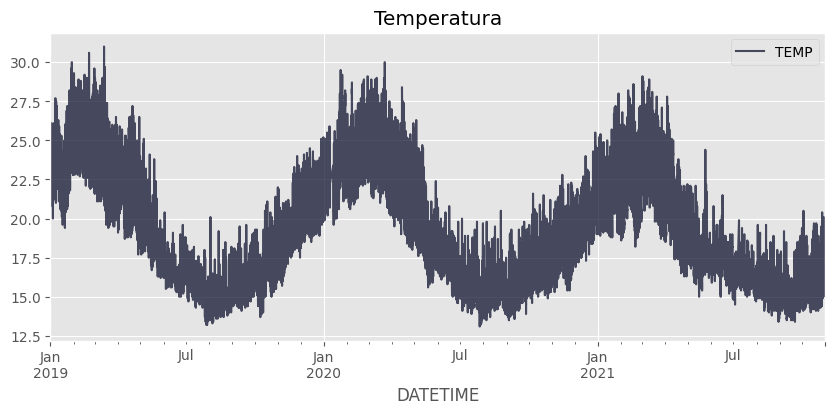

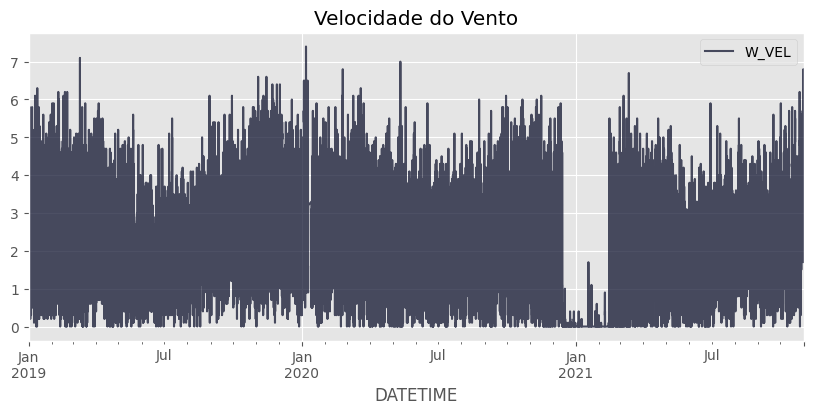

In [26]:
#Plots
ax = df_tempo["2019-01-01":].plot(
    y="TEMP", figsize=(10, 4), title="Temperatura", c=dark_blue, alpha=0.75,
)
df_tempo["2019-01-01":].plot(
    y="W_VEL",
    figsize=(10, 4),
    title="Velocidade do Vento",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

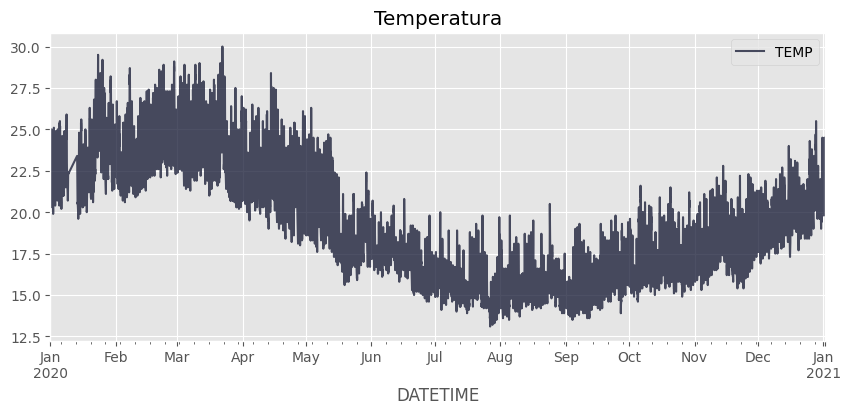

In [27]:
#Plots
ax = df_tempo.loc["2020-01-01":"2021-01-01"].plot(
    y="TEMP", figsize=(10, 4), title="Temperatura", c=dark_blue, alpha=0.75,
)

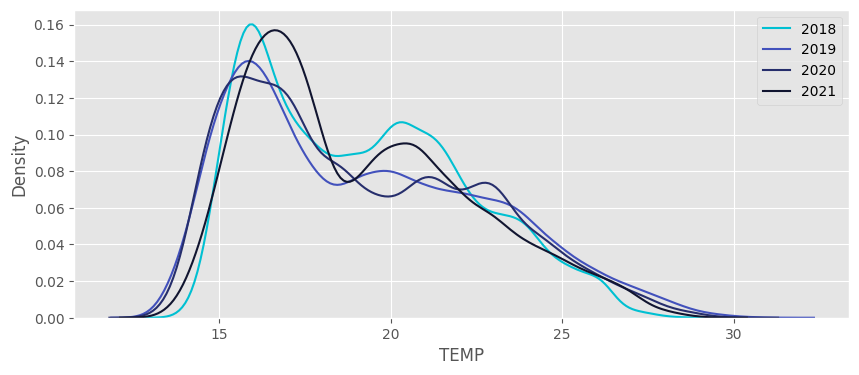

In [28]:
ax = sns.kdeplot(
    df_tempo.loc["2018-01-01":"2019-01-01"]["TEMP"], label="2018", color=teal,
)
sns.kdeplot(
    df_tempo.loc["2019-01-01":"2020-01-01"]["TEMP"], label="2019", color=light_blue, ax=ax,
)
sns.kdeplot(
    df_tempo.loc["2020-01-01":"2021-01-01"]["TEMP"], label="2020", color=blue, ax=ax,
)
sns.kdeplot(
    df_tempo.loc["2021-01-01":"2021-09-01"]["TEMP"], label="2021", color=dark_blue, ax=ax,
)

ax.legend()

#3 - Feature engineering

In [29]:
#Feature Engineering
#Busca feriados peruanos
peru_holidays = holidays.Peru()
dates_of_holidays = []
for date, name in sorted(
    holidays.Peru(
        years=[2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019, 2020, 2021]
    ).items()
):
    dates_of_holidays.append(date)

def criaFeatures(df):
  #Coluna temporaria
  df['temp'] = df.index.to_pydatetime()
  #Features de Data
  df["Holiday"] = df['temp'].apply(lambda t: 1 if t.date() in dates_of_holidays else 0)
  df["Quarter"] = df["temp"].apply(lambda t: t.quarter)
  df["DayOfYear"] = df["temp"].apply(lambda t: t.dayofyear)
  df["WeekOfYear"] = df["temp"].apply(lambda t: t.weekofyear)
  #Features auto correlacionadas
  df['lag_1'] = df['executado'].shift(1, freq = 'D')
  df['lag_7'] = df['executado'].shift(7, freq = 'D')
  df['lag_14'] = df['executado'].shift(14, freq = 'D')
  df['rolling_mean_1'] = df['executado'].rolling(window=96).mean()
  df['rolling_mean_7'] = df['executado'].rolling(window=672).mean()
  df['rolling_mean_14'] = df['executado'].rolling(window=1344).mean()
  df = df.drop(columns=["temp"], inplace=True)

criaFeatures(df_demanda_potencia)

In [30]:
#Junta com dados de temperatura
df_completo = df_demanda_potencia.join(df_tempo, lsuffix='', rsuffix='')

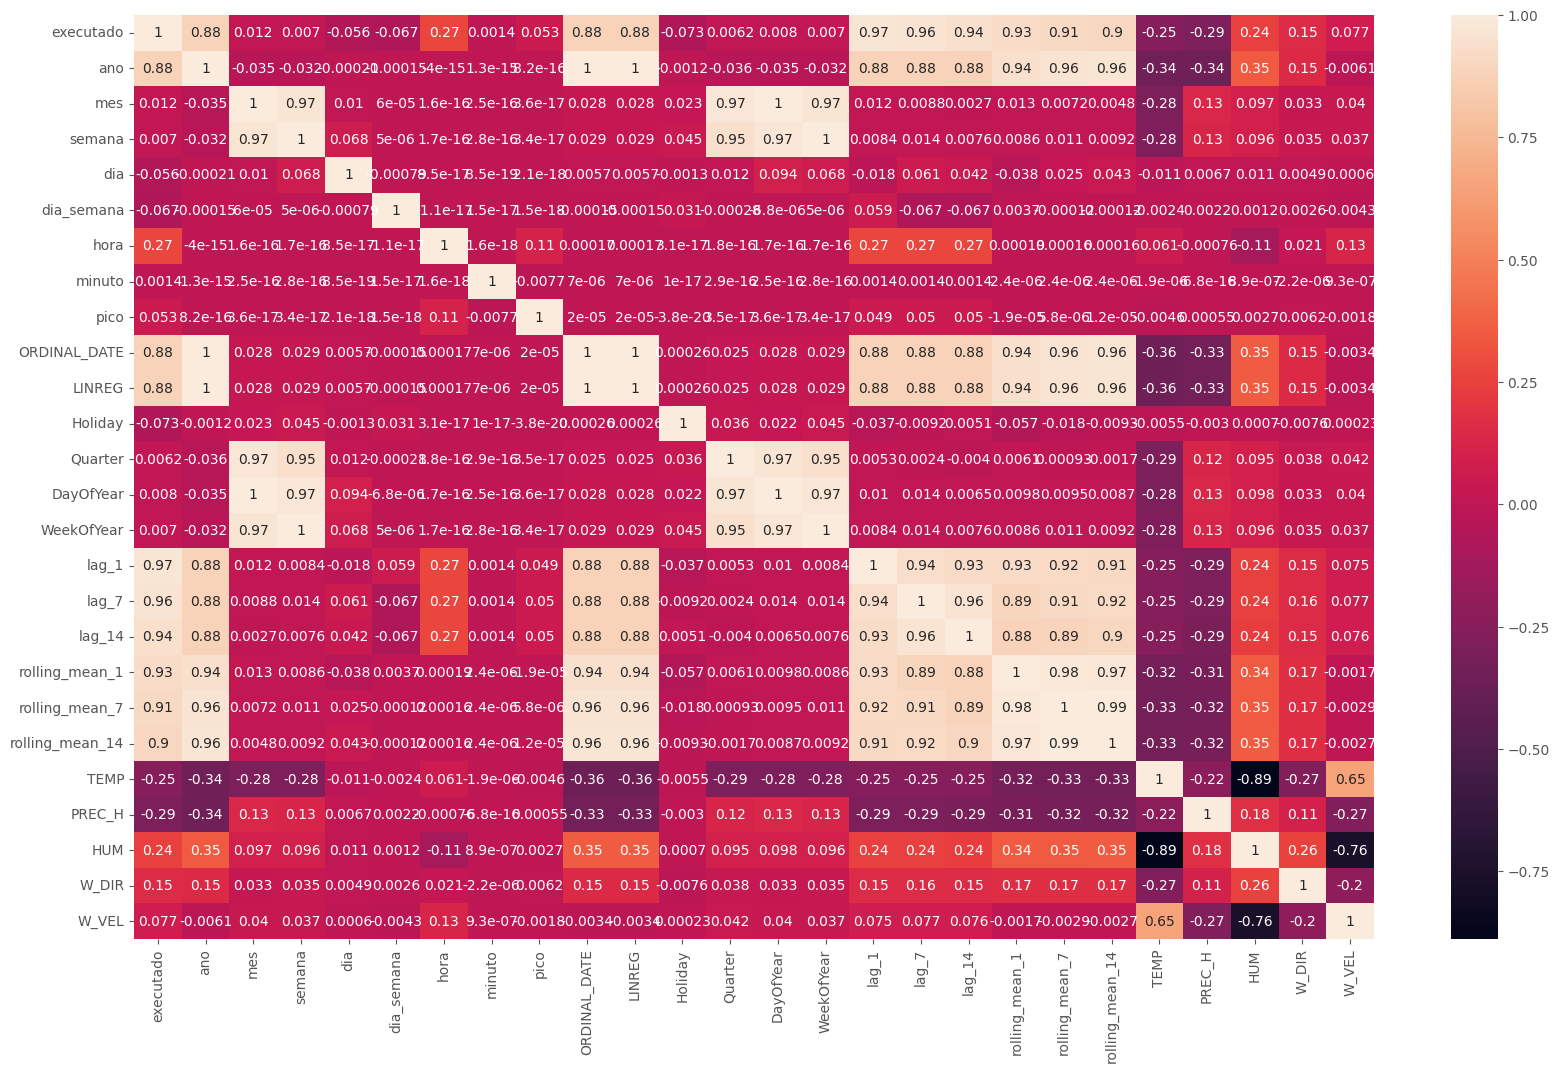

In [31]:
plt.figure(figsize=(20,12))
corr = df_completo.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.show()

#4 - Construção do Modelo Clássico

Referências:
- [A Brief Introduction to ARIMA and SARIMAX Modeling in Python](https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def)
- [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
- [How to Grid Search SARIMA Hyperparameters for Time Series Forecasting](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/)
- [Understand ARIMA and tune P, D, Q](https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q)

In [32]:
# Split dos dados de treino e teste
start_train = "2021-09-01-00:00"
end_train = "2021-09-28-23:45"
start_test = "2021-09-29-00:00"
end_test = "2021-09-29-23:45"

df_train = df_completo[start_train:end_train]
df_test = df_completo[start_test:end_test]
X_train = df_train.drop(columns=["executado","hora-minuto","dataref"])
y_train = df_train["executado"]
X_test = df_test.drop(columns=["executado","hora-minuto","dataref"])
y_test = df_test["executado"]

In [33]:
# Para tunar os hiper parâmetros do SARIMA (seasonal ARIMA), deseja-se ajustar principalmente os seguintes hiperparâmetros:
# p: Termo de Auto-regressão (AR), ou o termo de lag de valores prévios
# d: Termo Integral(I) para diferenciação de não estacionareidade
# q: Média móvel (MA) para o termo de offset
# P,D,Q: termos do ARIMA sazonais
# m: O número de elementos para um único período


# Grid Search
end_train_arima = "2021-09-27-23:45"
start_validation = "2021-09-28-00:00"
end_validation = "2021-09-28-23:45"
X_train_arima = X_train[:end_train_arima][['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]
X_val_arima = X_train[start_validation:end_validation][['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]

y_train_arima = y_train[:end_train_arima]
y_val_arima = y_train[start_validation:end_validation]

In [34]:
!pip install pmdarima
import pmdarima
from pmdarima.preprocessing import FourierFeaturizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00


In [35]:
fourier_feat = FourierFeaturizer(m = 96, k = 5)
exog_train_sarimax =  fourier_feat.fit_transform(y_train_arima)[1]
exog_train_sarimax.index = y_train_arima.index
exog_train_sarimax = pd.concat([exog_train_sarimax, X_train_arima], axis = 1)

In [36]:
model = pmdarima.auto_arima(y = y_train_arima,
                  X = exog_train_sarimax,
                  method = 'nm',
                  max_D = 2,
                  stepwise = True,
                  maxiter = 50,
                  trace = True)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27155.041, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27159.269, Time=1.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27157.876, Time=2.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27158.283, Time=3.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42200.196, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27145.621, Time=4.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=27147.173, Time=2.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27163.203, Time=1.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27159.822, Time=2.60 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=27132.390, Time=2.42 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=27127.519, Time=4.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=27107.025, Time=3.58 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=27108.212, Time=3.69 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=27106.472, Time=5.66 sec
 ARIMA(0,1,5)(0,0,0

In [37]:
fourier_feat = FourierFeaturizer(m = 96, k = 5)
exog_train_sarimax =  fourier_feat.fit_transform(y_train)[1]
exog_train_sarimax.index = y_train.index
exog_train_sarimax = pd.concat([exog_train_sarimax, X_train[['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]], axis = 1)

In [38]:
model = sm.tsa.statespace.SARIMAX(endog = y_train,
                                  order=(1,1,5),
                                  exog = exog_train_sarimax,
                                  freq='15T')

res = model.fit(n_jobs = -1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: n_jobs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
fourier_feat = FourierFeaturizer(m = 96, k = 5)
fourier_feat.fit(y_train)
exog_val_sarimax =  fourier_feat.transform(X = y_train, n_periods=y_test.shape[0])[1]

exog_val_sarimax.index = y_test.index
exog_val_sarimax = pd.concat([exog_val_sarimax, X_test[['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]], axis = 1)
y_predict_serie = res.predict(start = y_test.index[0], end = y_test.index[-1], exog= exog_val_sarimax)

y_predict = pd.DataFrame()
y_predict['pred'] = y_predict_serie

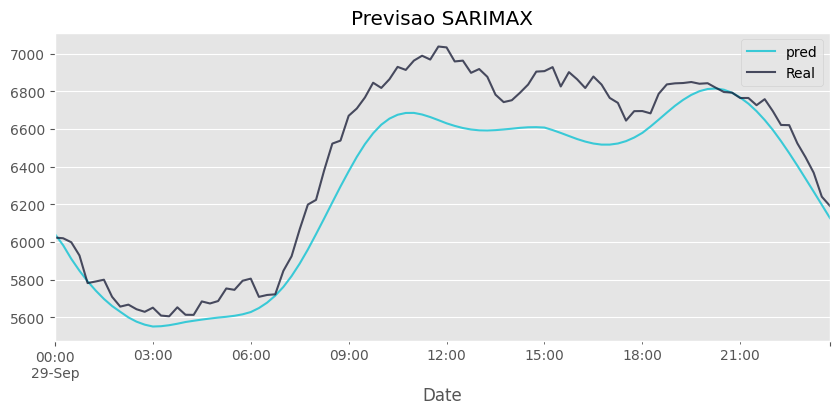

In [40]:
y_predict.plot(
     figsize=(10, 4), title="Demanda de Potência", c=teal, alpha=0.75, label = 'Previsto'
)

y_test.plot(
    y="executado",
    figsize=(10, 4),
    title="Previsao SARIMAX",
    c=dark_blue,
    alpha=0.75,
    label = 'Real'
)
plt.legend()
plt.show()


# Backtest Sarimax

In [41]:
!pip install tqdm
from tqdm import tqdm
import datetime
import warnings
warnings.simplefilter("ignore")

def backtest_sarimax(df,start_date, y_column = 'executado'):

  ts_start_date = pd.to_datetime(start_date)
  dates_tested = df.loc[ts_start_date:, :].index
  y_real = df[['executado']].loc[start_date:, :]
  last_date = df.index[-1]

  pred_data = pd.Series()

  for date_tested in tqdm(dates_tested):
    if(str(date_tested) == str(last_date)):
      break

    df_train = df.loc[:date_tested, :]
    # print(df_train.tail(1))
    X_train_arima = df_train[['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]
    y_train_arima = df_train[y_column]


    fourier_feat = FourierFeaturizer(m = 96, k = 5)

    exog_train_sarimax =  fourier_feat.fit_transform(y_train_arima)[1]
    exog_train_sarimax.index = y_train_arima.index

    exog_train_sarimax = pd.concat([exog_train_sarimax, X_train_arima], axis = 1)

    del fourier_feat
    fourier_feat = FourierFeaturizer(m = 96, k = 5)
    fourier_feat.fit(y_train_arima)
    exog_val_sarimax =  fourier_feat.transform(y = y_train_arima, n_periods=1)
    # return (exog_val_sarimax)

    val_date = date_tested + datetime.timedelta(minutes = 15)

    # X_train_arima = df.loc[val_date, :][['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]
    X_val_arima = df.loc[val_date][['TEMP', 'PREC_H',	'HUM', 'W_DIR', 'W_VEL']]


    exog_val_sarimax = exog_val_sarimax[1]
    exog_val_sarimax.index = [val_date]


    exog_val_sarimax = pd.concat([exog_val_sarimax, pd.DataFrame(X_val_arima).T], axis = 1)
    # print(exog_val_sarimax)

    model = sm.tsa.statespace.SARIMAX(endog = y_train_arima,
                                      order=(1,1,5),
                                      exog = exog_train_sarimax,
                                      freq='15min')
    model = model.fit(n_jobs = -1)

    y_predict = model.predict(start=val_date, end=val_date, exog = exog_val_sarimax)

    pred_data = pd.concat([pred_data, y_predict])

  y_real['pred'] = pred_data

  return y_real.dropna()


# backtest = backtest_sarimax(df = df_completo_arima.loc['2021-09-15 00:00:00':].dropna(), start_date='2021-09-30 00:00:00')

In [42]:
# backtest.plot()

#5 - Construção do Modelo de Machine Learning

In [43]:
# Split dos dados de treino e teste
start_train = "2018-01-01-00:00"
end_train = "2021-09-28-23:45"
start_test = "2021-09-29-00:00"
end_test = "2021-09-29-23:45"

df_train = df_completo[start_train:end_train]
df_test = df_completo[start_test:end_test]
X_train = df_train.drop(columns=["executado","hora-minuto","dataref", "DATE"])
y_train = df_train["executado"]
X_test = df_test.drop(columns=["executado","hora-minuto","dataref", "DATE"])
y_test = df_test["executado"]

In [44]:
#Gridsearch
cv = TimeSeriesSplit(n_splits=5)

parameters = {"learning_rate": [0.1, 0.05],
              #The learning rate is the shrinkage you do at every step you are making

               "gamma" : [0.01, 0.1, 0.3, 0.5],
              #A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
              #Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

               "max_depth": [2, 4, 7, 10],
              #The maximum depth of a tree, same as GBM.
              #Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

               "colsample_bytree": [0.3, 0.6],
              #Denotes the fraction of columns to be randomly samples for each tree.

               "subsample": [0.2, 0.4, 0.5],
              #Denotes the fraction of observations to be randomly samples for each tree.
              #Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

               "reg_alpha": [0, 0.5, 1],
              #L1 regularization term on weights. Increasing this value will make model more conservative.

               "reg_lambda": [1, 1.5, 2, 3, 4.5],
              #L2 regularization term on weights. Increasing this value will make model more conservative.

               "min_child_weight": [1, 3, 5, 7],
              #The larger min_child_weight is, the more conservative the algorithm will be.

               "n_estimators": [100, 250, 500]}
              #Number of tress or rounds. The more, the higher the risk of overfitting

xgbr = xgb.XGBRegressor(objective='reg:squarederror' , sampling_method = 'gradient_based', tree_method = 'gpu_hist', enable_categorical=True)

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgbr,
                              param_distributions=parameters,
                              verbose=3,
                              random_state=42,
                              cv=cv,
                              error_score='raise'
                              )

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.866 total time=   2.8s
[CV 2/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.919 total time=   0.9s
[CV 3/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.702 total time=   0.7s
[CV 4/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.264 total time=   0.7s
[CV 5/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.903 tot

In [45]:
model_xgboost.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=np.nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None, enable_categorical=True)

#6 - Backtest

In [47]:
#MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
def expandingWindowDiario(df, test_start_date, stop_date):
  mae_modelo = []
  mape_modelo = []
  column_names = ["Date", "Executado"	,"EXECUTADO_MODELO"]
  df_previsao = pd.DataFrame(columns = column_names)
  train_start_date = dt.datetime(2018,1,1,0,0,0)
  train_end_date = test_start_date
  test_end_date = test_start_date + timedelta(hours = 24)
  while test_start_date < stop_date:
    print("TRAIN:",train_start_date," - ",train_end_date)
    print("TEST:",test_start_date," - ",test_end_date)

    df_train=df.loc[train_start_date:train_end_date].copy()
    df_test=df.loc[test_start_date:test_end_date].copy()

    X_training = df_train.drop(columns=["executado"]).copy()
    y_training = df_train["executado"].copy()
    X_test = df_test.drop(columns=["executado"]).copy()
    y_test = df_test["executado"].copy()

    reg.fit(X_training, y_training,
          verbose=False)
    yhat = reg.predict(X_test)


    #Erro
    maeTeste = mean_absolute_error(y_test,yhat)
    mae_modelo.append(maeTeste)
    mape_teste = mean_absolute_percentage_error(y_test,yhat)
    mape_modelo.append(mape_teste)
    d = {'Date' :y_test.index ,'Real':y_test,'Modelo':yhat}
    previsao = pd.DataFrame(data=d)
    df_previsao=df_previsao.append(previsao)
    #Avança
    train_end_date = train_end_date + timedelta(days = 1)
    test_start_date = test_start_date + timedelta(days = 1)
    test_end_date = test_end_date + timedelta(days = 1)
  return ([df_previsao,mae_modelo, mape_modelo])


In [49]:
df_completo_xgboost=df_completo.drop(columns=["hora-minuto","dataref","semana", "DATE"]).copy()

In [50]:
df_previsao,mae_full,mape_full = expandingWindowDiario(df_completo_xgboost,dt.datetime(2021,9,28,0,0,0),dt.datetime(2021,9,29,23,45,0))

TRAIN: 2018-01-01 00:00:00  -  2021-09-28 00:00:00
TEST: 2021-09-28 00:00:00  -  2021-09-29 00:00:00
TRAIN: 2018-01-01 00:00:00  -  2021-09-29 00:00:00
TEST: 2021-09-29 00:00:00  -  2021-09-30 00:00:00


In [51]:
df_previsao = df_previsao.set_index("Date").copy()

<Axes: title={'center': 'Previsão'}, xlabel='Date'>

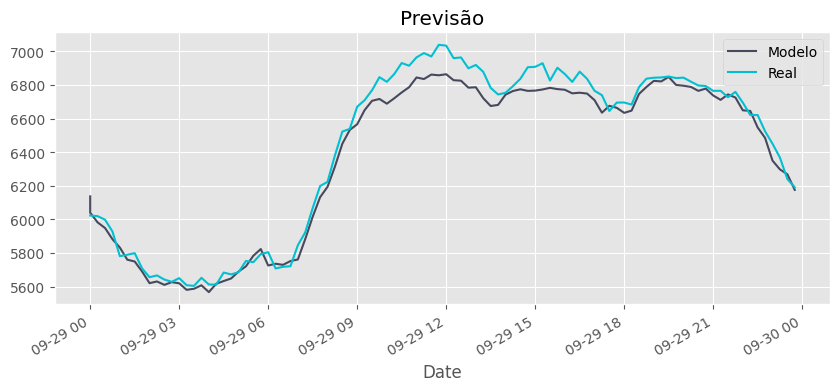

In [52]:
ax = df_previsao.loc["2021-09-29"].plot(
    y="Modelo", figsize=(10, 4), title="Previsão", c=dark_blue, alpha=0.75, label = "Modelo"
)
df_previsao.loc["2021-09-29"].plot(
    y="Real", label="Real", color=teal, ax=ax
)

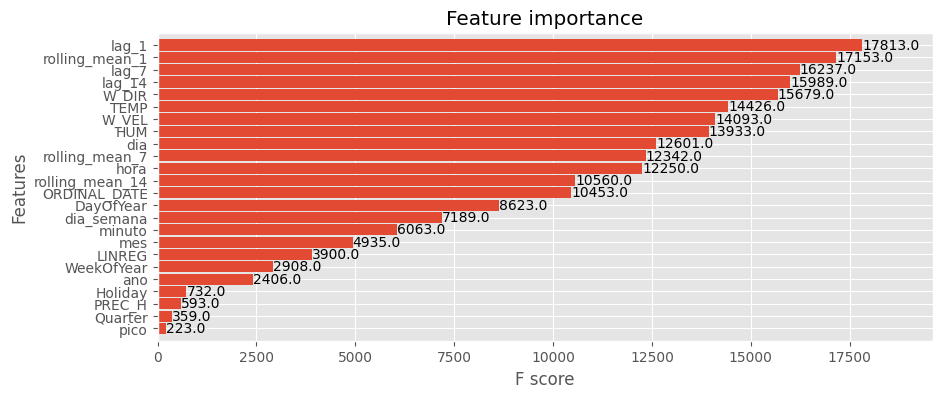

In [53]:
_ = plot_importance(reg, height=0.9)

#7 - Previsão do dia  29/09/2021

<Axes: title={'center': 'Previsão 29/09/2021'}, xlabel='Date'>

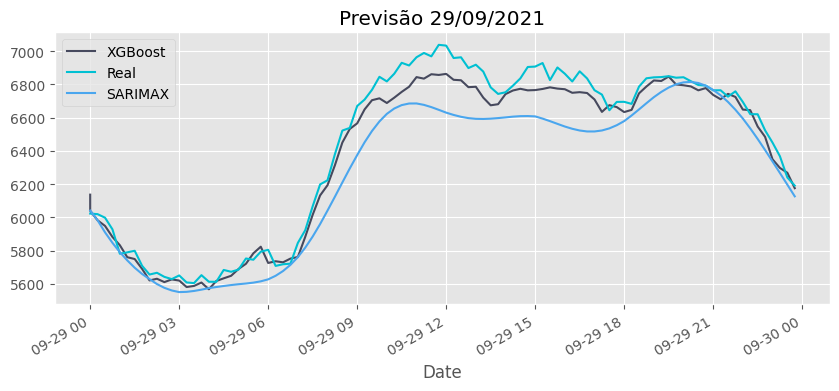

In [54]:
ax = df_previsao.loc["2021-09-29"].plot(
    y="Modelo", figsize=(10, 4), title="Previsão 29/09/2021", c=dark_blue, alpha=0.75, label = "XGBoost"
)
df_previsao.loc["2021-09-29"].plot(
    y="Real", label="Real", color=teal, ax=ax
)
y_predict.loc["2021-09-29"].plot(
     y="pred",label="SARIMAX", color=cian, ax=ax
)
